In [21]:
! rm -rf ./models && git clone https://github.com/tensorflow/models.git \
    && sed -i "s#ImageFont.truetype('arial.ttf', 24)#ImageFont.truetype('arial.ttf', 50)#g" ./models/research/object_detection/utils/visualization_utils.py \
    && cp /usr/share/fonts/truetype/dejavu/DejaVuSans.ttf /usr/share/fonts/truetype/dejavu/arial.ttf

Cloning into 'models'...
remote: Enumerating objects: 81352, done.
remote: Counting objects: 100% (158/158), done.
remote: Compressing objects: 100% (96/96), done.
remote: Total 81352 (delta 79), reused 133 (delta 62), pack-reused 81194
Receiving objects: 100% (81352/81352), 596.09 MiB | 29.21 MiB/s, done.
Resolving deltas: 100% (58015/58015), done.
Updating files: 100% (3347/3347), done.


In [22]:
! cd models/research \
    && protoc object_detection/protos/*.proto --python_out=. \
    && cp object_detection/packages/tf2/setup.py . && \
    python3 -m pip install --use-feature=2020-resolver .

Processing /kaggle/working/models/research
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 2.5 MB/s eta 0:00:0000:0100:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.0 MB/s eta 0:00:00a 0:00:01
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=21878293 sha256=a949c32fffc6bb69b77e9871a35ff4c78d47d57e349365f5547015acb878b7c3
  Stored in directory: /tmp/pip-ephem-wheel-cache-ntcuglha/wheels/d3/e0/37/addaa349be05bc9a8e02e02876c3154afc70272d2a09a30920
Successfully built object-detection
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.21.12
    Uninstalling protobuf-4.21.12:
      Successfully uninstalled protobuf-4.21.12
  Attempting uninstall: object-detection
    Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-detection-0.1
ERROR: pip's dependency resolver does not currently t

In [23]:
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
from matplotlib import pyplot as plt
from tensorflow.python.util import compat

from google.protobuf import text_format
import pprint
import json
import os


In [24]:
!pip install --upgrade protobuf

  Using cached protobuf-4.21.12-cp37-abi3-manylinux2014_x86_64.whl (409 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.6
    Uninstalling protobuf-3.19.6:
      Successfully uninstalled protobuf-3.19.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
wandb 0.12.21 requires protobuf<4.0dev,>=3.12.0, but you have protobuf 4.21.12 which is incompatible.
tfx-bsl 1.9.0 requires google-api-python-client<2,>=1.7.11, but you have google-api-python-client 2.52.0 which is incompatible.
tfx-bsl 1.9.0 requires protobuf<3.21,>=3.13, but you have protobuf 4.21.12 which is incompatible.
tfx-bsl 1.9.0 requires pyarrow<6,>=1, but you have pyarrow 7.0.0 which is incompatible.
tensorflow 2.11.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 4.21.12 w

In [25]:
from tensorflow.core.protobuf import saved_model_pb2

In [26]:
from object_detection.utils import visualization_utils as vis_util
from object_detection.utils import dataset_util, label_map_util
from object_detection.protos import string_int_label_map_pb2

In [27]:
def reconstruct(pb_path):
    if not os.path.isfile(pb_path):
        print("Error: %s not found" % pb_path)

    print("Reconstructing Tensorflow model")
    detection_graph = tf.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.compat.v1.GraphDef()
        with tf.io.gfile.GFile(pb_path, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
    print("Success!")
    return detection_graph

In [28]:
def image2np(image):
    (w, h) = image.size
    return np.array(image.getdata()).reshape((h, w, 3)).astype(np.uint8)

def image2tensor(image):
    npim = image2np(image)
    return np.expand_dims(npim, axis=0)

%matplotlib inline
def detect(detection_graph, test_image_path):
    with detection_graph.as_default():
        gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.01)
        with tf.compat.v1.Session(graph=detection_graph,config=tf.compat.v1.ConfigProto(gpu_options=gpu_options)) as sess:
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
            detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')

            image = Image.open(test_image_path)
            (boxes, scores, classes, num) = sess.run(
                [detection_boxes, detection_scores, detection_classes, num_detections],
                feed_dict={image_tensor: image2tensor(image)}
            )

            npim = image2np(image)
            vis_util.visualize_boxes_and_labels_on_image_array(
                npim,
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                np.squeeze(scores),
                category_index,
                use_normalized_coordinates=True,
                line_thickness=15)
            plt.figure(figsize=(12, 8))
            plt.imshow(npim)
            plt.show()

In [29]:
import os
DATA_DIR = '/kaggle/input/tacotrashdataset/data'
ANNOTATIONS_FILE = os.path.join(DATA_DIR, 'annotations.json')
NCLASSES = 3

In [30]:
import json
with open(ANNOTATIONS_FILE) as json_file:
    data = json.load(json_file)
    
categories = data['categories']

In [31]:
print('Building label map from examples')

dict = {
    "Aluminium foil" : "Recyclable",
    "Battery": "Hazardous",
    "Blister pack" : "Recyclable",
    "Bottle" : "Recyclable",
    "Plastic" : "Recyclable",
    "Bottle cap" : "Non Recyclable",
    "Broken glass" : "Non Recyclable",
    "Can" : "Recyclable",
    "Carton" : "Recyclable",
    "Cup" : "Recyclable",
    "Food waste" : "Organic",
    "Glass jar" : "Recyclable",
    "Lid" : "Non Recyclable",
    "Other plastic" : "Non Recyclable",
    "Paper" : "Recyclable",
    "Paper bag" : "Recyclable",
    "Plastic bag & wrapper" : "Recyclable",
    "Plastic container" : "Recyclable",
    "Plastic glooves" : "Non Recyclable",
    "Plastic utensils" : "Recyclable",
    "Pop tab" : "Non Recyclable",
    "Rope & strings" : "Recyclable",
    "Scrap metal" : "Recyclable",
    "Shoe" : "Recyclable",
    "Squeezable tube" : "Recyclable",
    "Styrofoam piece" : "Non Recyclable",
    "Straw" : "Non Recyclable",
    "Unlabeled litter" : "Non Recyclable",
    "Cigarette" : "Hazardous",
}
labelmap = string_int_label_map_pb2.StringIntLabelMap()
for idx,category in enumerate(categories):
    item = labelmap.item.add()
    # label map id 0 is reserved for the background label
    item.id = int(category['id'])+1
    try:
        item.name = dict[category['supercategory']]
    except:
        item.name = category['supercategory']
    print(category)

with open('./labelmap.pbtxt', 'w') as f:
    f.write(text_format.MessageToString(labelmap))

print('Label map witten to labelmap.pbtxt')

with open('./labelmap.pbtxt') as f:
    pprint.pprint(f.readlines())

Building label map from examples
{'supercategory': 'Aluminium foil', 'id': 0, 'name': 'Aluminium foil'}
{'supercategory': 'Battery', 'id': 1, 'name': 'Battery'}
{'supercategory': 'Blister pack', 'id': 2, 'name': 'Aluminium blister pack'}
{'supercategory': 'Blister pack', 'id': 3, 'name': 'Carded blister pack'}
{'supercategory': 'Bottle', 'id': 4, 'name': 'Other plastic bottle'}
{'supercategory': 'Bottle', 'id': 5, 'name': 'Clear plastic bottle'}
{'supercategory': 'Bottle', 'id': 6, 'name': 'Glass bottle'}
{'supercategory': 'Bottle cap', 'id': 7, 'name': 'Plastic bottle cap'}
{'supercategory': 'Bottle cap', 'id': 8, 'name': 'Metal bottle cap'}
{'supercategory': 'Broken glass', 'id': 9, 'name': 'Broken glass'}
{'supercategory': 'Can', 'id': 10, 'name': 'Food Can'}
{'supercategory': 'Can', 'id': 11, 'name': 'Aerosol'}
{'supercategory': 'Can', 'id': 12, 'name': 'Drink can'}
{'supercategory': 'Carton', 'id': 13, 'name': 'Toilet tube'}
{'supercategory': 'Carton', 'id': 14, 'name': 'Other car

In [32]:
label_map = label_map_util.load_labelmap('labelmap.pbtxt')
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NCLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [33]:
detection_graph = reconstruct("../input/trained-models-taco-trash-annotations-in-context/ssd_mobilenet_v2_taco_2018_03_29.pb")

Reconstructing Tensorflow model
Success!


In [34]:
type(detection_graph)

tensorflow.python.framework.ops.Graph

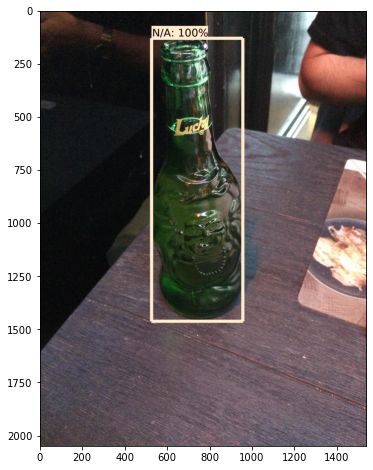

In [35]:
detect(detection_graph, '/kaggle/input/tacotrashdataset/data/batch_1/000006.jpg')

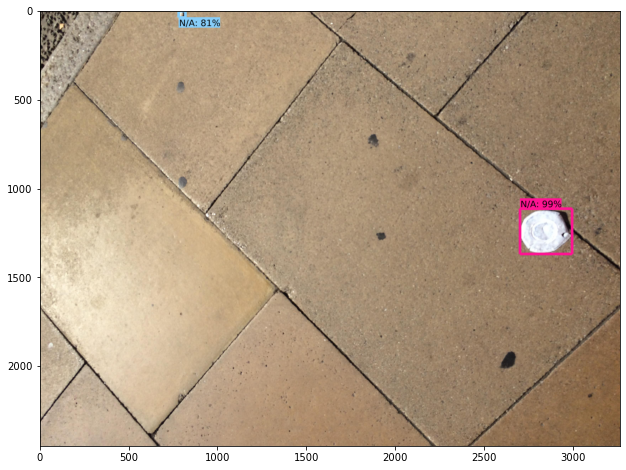

In [36]:
detect(detection_graph, '/kaggle/input/tacotrashdataset/data/batch_3/IMG_4852.JPG')

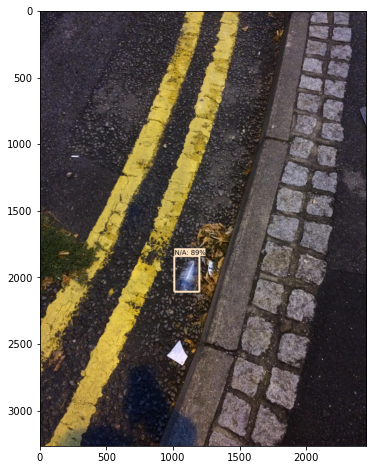

In [37]:
detect(detection_graph, '/kaggle/input/tacotrashdataset/data/batch_5/000000.JPG')

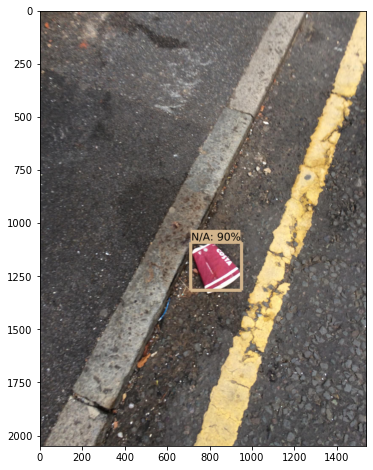

In [38]:
detect(detection_graph, '/kaggle/input/tacotrashdataset/data/batch_1/000003.jpg')

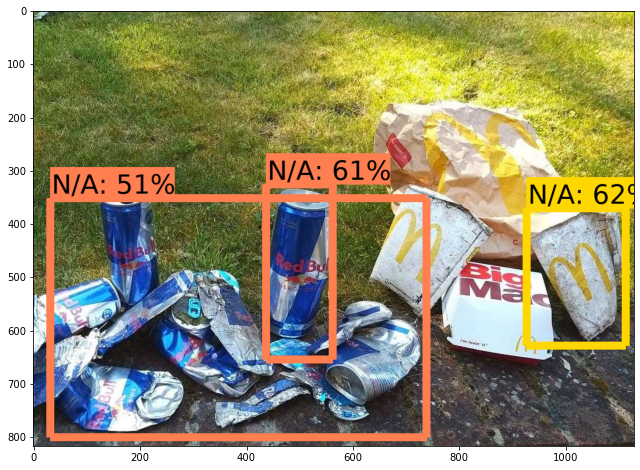

In [39]:
detect(detection_graph, '/kaggle/input/d/devanshkapri/testing/PU3PFEBP8U914NCK3LQ3.jpg')

In [40]:
! pip install pyyaml h5py

In [47]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [41]:
mkdir fine_tuned_model


In [46]:
! python research/object_detection/detection_graph.py --input_type image_tensor --pipeline_config_path ssd_mobilenet_v2_taco_2018_03_29.config --trained_checkpoint_prefix  train/model.ckpt --output_directory fine_tuned_model

python: can't open file 'research/object_detection/detection_graph.py': [Errno 2] No such file or directory


In [ ]:
import pandas as pd
from flask_cors import CORS, cross_origin
import pickle
from flask import Flask, jsonify, request
import numpy as np
import sklearn
import random

app = Flask(__name__)
cors = CORS(app)

model = pickle.load(open('days_between_requests_model.pkl', 'rb'))


@app.route('/predict', methods=['POST'])
def predict():
  latitude = request.json["latitude"]
  longitude = request.json["longitude"]
  print(longitude)
  print(latitude)
  filename = 'days_between_requests_model.pkl'
  kmeans = pickle.load(open(filename, 'rb'))
  cluster_averages = pickle.load(open('cluster_averages.pkl', 'rb'))

  print(cluster_averages)

  # Define a new location's latitude and longitude
  new_location = np.array([[latitude, longitude]])

  # Compute the cluster label for the new location
  cluster_label = kmeans.predict(new_location)[0]
  print(cluster_label)

  centers = pickle.load(open('centers.pkl', 'rb'))
  print(centers)
  # Look up the average number of days between requests for the cluster
  prediction = cluster_averages[cluster_label]

  return jsonify({
    'prediction': round(prediction),
    'centers': centers[0].tolist(),
  })


if __name__ == '__main__':
  app.run(debug=True, host='0.0.0.0', port=5000)
